## Import the libraries

In [3]:
import os
import pandas as pd
import yfinance as yf
from newsapi import NewsApiClient
from datetime import datetime, timedelta
from dotenv import load_dotenv
load_dotenv()

import nltk
from nltk.sentiment.vader import SentimentIntensityAnalyzer

## Fetch the stock OHLC

In [4]:
stock_data= yf.download(tickers= 'MSFT', period= '5y')
stock_data.tail()

[*********************100%***********************]  1 of 1 completed


,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2021-01-04,222.529999,223.000000,214.809998,217.690002,217.690002,37130100
2021-01-05,217.259995,218.520004,215.699997,217.899994,217.899994,23823000
2021-01-06,212.169998,216.490005,211.940002,212.250000,212.250000,35930700
2021-01-07,214.039993,219.339996,213.710007,218.289993,218.289993,27694500
2021-01-08,218.679993,220.580002,217.029999,219.619995,219.619995,22949400


In [5]:
# Get only the closing price and round to 1 decimal
stock_close= round (stock_data['Close'], 1)
stock_close.tail()

Date
2021-01-04    217.7
2021-01-05    217.9
2021-01-06    212.2
2021-01-07    218.3
2021-01-08    219.6
Name: Close, dtype: float64

In [6]:
# Calculate the daily returns
returns= stock_close.pct_change().dropna()
returns.tail()

Date
2021-01-04   -0.021133
2021-01-05    0.000919
2021-01-06   -0.026159
2021-01-07    0.028746
2021-01-08    0.005955
Name: Close, dtype: float64

In [41]:
returns_df= pd.DataFrame(returns)
returns_df.sort_index(ascending= False, inplace= True)

returns_df.rename(columns= {'Close':'pct_change'}, inplace= True)
returns_df.head()

,pct_change
Date,
2021-01-08,0.005955
2021-01-07,0.028746
2021-01-06,-0.026159
2021-01-05,0.000919
2021-01-04,-0.021133


### Download the VADER Lexicon

In [8]:
nltk.download('vader_lexicon')

# Initialize the sentiment analyzer
analyzer= SentimentIntensityAnalyzer()

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     C:\Users\sathe\AppData\Roaming\nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


### Fetch the news

In [62]:
import requests
import json

In [63]:
stock_news_api= os.getenv("STOCK_NEWS_API")
type (stock_news_api)

str

In [64]:
# Define the base request URL
request_url = "https://stocknewsapi.com/api/v1?tickers=MSFT&items=50&token="

# Concatenate request_url and api_key. Store as new variable
request_url= request_url+ stock_news_api

In [65]:
# Execute get request
response_data= requests.get(request_url).json()

In [66]:
print (json.dumps (response_data, indent= 4))

{
    "data": [
        {
            "news_url": "https://www.fool.com/investing/2021/01/08/is-microsoft-stock-a-buy/",
            "image_url": "https://cdn.snapi.dev/images/v1/m/5/104726953-microsoft-satya-nadella-2-high-res530x298.jpg",
            "title": "Is Microsoft Stock a Buy?",
            "text": "Despite already being a $1.6 trillion company, Microsoft has a few tricks up its sleeve to grow even more.",
            "source_name": "The Motley Fool",
            "date": "Fri, 08 Jan 2021 08:15:00 -0500",
            "topics": [],
            "sentiment": "Positive",
            "type": "Article",
            "tickers": [
                "MSFT"
            ]
        },
        {
            "news_url": "https://www.businessinsider.com/faang-stocks-rebound-after-democratic-wins-georgia-shake-big-tech-2021-1",
            "image_url": "https://cdn.snapi.dev/images/v1/f/a/faang-stocks-rebound-after-democratic-wins-in-georgia-shake-big-tech.jpg",
            "title": "FAANG stoc

In [132]:
all_articles= []
all_sentiments= []
all_dates= []
for article in response_data['data']:
    all_articles.append(article['text'])
    all_sentiments.append(article['sentiment'])
    all_dates.append(article['date'])

In [133]:
all_articles_df= pd.DataFrame(all_articles, columns= ['text'])
all_articles_df.head()

,text
0,"Despite already being a $1.6 trillion company,..."
1,Jon Ossoff and Raphael Warnock pulled off narr...
2,It's been an ugly start to 2021 for Microsoft ...
3,"With bitcoin touching new highs, it's imperati..."
4,"Dick Costolo, 01 Advisors managing partner and..."


In [134]:
all_sentiments_df= pd.DataFrame(all_sentiments, columns= ['sentiment'])
all_sentiments_df.head()

,sentiment
0,Positive
1,Positive
2,Positive
3,Positive
4,Negative


In [135]:
all_dates_df= pd.DataFrame(all_dates, columns= ['date'])
all_dates_df['date']= pd.to_datetime(all_dates_df['date']).dt.date

all_dates_df.head()

,date
0,2021-01-08
1,2021-01-07
2,2021-01-07
3,2021-01-07
4,2021-01-06


In [141]:
text_sentiment= pd.concat([all_dates_df, all_articles_df, all_sentiments_df], axis= 1)
text_sentiment.head()

,date,text,sentiment
0,2021-01-08,"Despite already being a $1.6 trillion company,...",Positive
1,2021-01-07,Jon Ossoff and Raphael Warnock pulled off narr...,Positive
2,2021-01-07,It's been an ugly start to 2021 for Microsoft ...,Positive
3,2021-01-07,"With bitcoin touching new highs, it's imperati...",Positive
4,2021-01-06,"Dick Costolo, 01 Advisors managing partner and...",Negative


In [142]:
text_sentiment.set_index('date', inplace= True)
text_sentiment.head()

,text,sentiment
date,,
2021-01-08,"Despite already being a $1.6 trillion company,...",Positive
2021-01-07,Jon Ossoff and Raphael Warnock pulled off narr...,Positive
2021-01-07,It's been an ugly start to 2021 for Microsoft ...,Positive
2021-01-07,"With bitcoin touching new highs, it's imperati...",Positive
2021-01-06,"Dick Costolo, 01 Advisors managing partner and...",Negative


In [159]:
text_sentiment_returns= pd.merge(text_sentiment, returns_df, left_index= True, right_index= True)
text_sentiment_returns.sort_index(ascending= False, inplace= True)
text_sentiment_returns.head()

,text,sentiment,pct_change
2021-01-08,"Despite already being a $1.6 trillion company,...",Positive,0.005955
2021-01-07,"With bitcoin touching new highs, it's imperati...",Positive,0.028746
2021-01-07,It's been an ugly start to 2021 for Microsoft ...,Positive,0.028746
2021-01-07,Jon Ossoff and Raphael Warnock pulled off narr...,Positive,0.028746
2021-01-06,The Georgia Senate runoffs remain too close to...,Negative,-0.026159


In [160]:
text_sentiment_returns.reset_index(inplace= True)
text_sentiment_returns.head()

,index,text,sentiment,pct_change
0,2021-01-08,"Despite already being a $1.6 trillion company,...",Positive,0.005955
1,2021-01-07,"With bitcoin touching new highs, it's imperati...",Positive,0.028746
2,2021-01-07,It's been an ugly start to 2021 for Microsoft ...,Positive,0.028746
3,2021-01-07,Jon Ossoff and Raphael Warnock pulled off narr...,Positive,0.028746
4,2021-01-06,The Georgia Senate runoffs remain too close to...,Negative,-0.026159


### Create the sentiment scores DF

In [161]:
polarity= []

for content in text_sentiment['text']:
    try:
        # Calculate the polarity score
        sentiment= analyzer.polarity_scores(content)
        compound= sentiment['compound']
#         positive= sentiment['pos']
#         negative= sentiment['neg']
#         neutral= sentiment['neu']
        
        polarity.append({
            "compound": compound,
#             "positive": positive,
#             "negative": negative,
#             "neutral": neutral
        })
        
    except AttributeError:
        pass
    
# Create dataframe
polarity_df= pd.DataFrame(polarity)
polarity_df.head()

,compound
0,-0.1280
1,-0.0772
2,0.8765
3,0.3612
4,-0.5106


In [162]:
text_sentiment_returns_polarity= pd.concat([text_sentiment_returns, polarity_df], axis= 1)
text_sentiment_returns_polarity.head()

,index,text,sentiment,pct_change,compound
0,2021-01-08,"Despite already being a $1.6 trillion company,...",Positive,0.005955,-0.1280
1,2021-01-07,"With bitcoin touching new highs, it's imperati...",Positive,0.028746,-0.0772
2,2021-01-07,It's been an ugly start to 2021 for Microsoft ...,Positive,0.028746,0.8765
3,2021-01-07,Jon Ossoff and Raphael Warnock pulled off narr...,Positive,0.028746,0.3612
4,2021-01-06,The Georgia Senate runoffs remain too close to...,Negative,-0.026159,-0.5106


## Tokenization, Lemmatization

In [58]:
# Importing the Libraries and Functions
from nltk.tokenize import word_tokenize, sent_tokenize
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer, PorterStemmer
from string import punctuation
import re

In [59]:
# Instantiate the lemmatizer
lemmatizer= WordNetLemmatizer()

In [60]:
def tokenizer(text):
    """Tokenizes text."""
    
    # Remove the stop words
    stop_words= set (stopwords.words('english'))
   
    # Remove the punctuation and substitute
    non_alpha= re.compile('[^a-zA-Z ]')
    re_clean= non_alpha.sub('', str (text))
    
    # Tokenize the words
    words= word_tokenize(re_clean)
    
    # Lemmatize Article words into root words
    root_words= []
    for values in words:
        root_words.append(lemmatizer.lemmatize(values))
        
    # Remove stop words and Convert the words to lowercase
    tokens= []
    for all_words in root_words:
        if all_words.lower() not in stop_words:
            tokens.append(all_words.lower())
    
    return tokens

In [75]:
# Apply the tokenizer function to the news text column
text_sentiment_polarity['tokenized']= text_sentiment_polarity['text'].apply(tokenizer)
text_sentiment_polarity.head()

,text,sentiment,compound,negative,neutral,positive,tokenized
0,"Despite already being a $1.6 trillion company,...",Positive,-0.1280,0.086,0.914,0.000,"[despite, already, trillion, company, microsof..."
1,Jon Ossoff and Raphael Warnock pulled off narr...,Positive,-0.0772,0.035,0.935,0.030,"[jon, ossoff, raphael, warnock, pulled, narrow..."
2,It's been an ugly start to 2021 for Microsoft ...,Positive,0.8765,0.092,0.705,0.203,"[ugly, start, microsoft, stock, wary, investor..."
3,"With bitcoin touching new highs, it's imperati...",Positive,0.3612,0.000,0.915,0.085,"[bitcoin, touching, new, high, imperative, wat..."
4,"Dick Costolo, 01 Advisors managing partner and...",Negative,-0.5106,0.148,0.852,0.000,"[dick, costolo, advisors, managing, partner, f..."


## N-grams, WordCloud

In [80]:
# Import the libraries and functions
from wordcloud import WordCloud
import matplotlib.pyplot as plt
plt.style.use('seaborn-whitegrid')
import matplotlib as mpl
mpl.rcParams['figure.figsize'] = [15.0, 15.0]

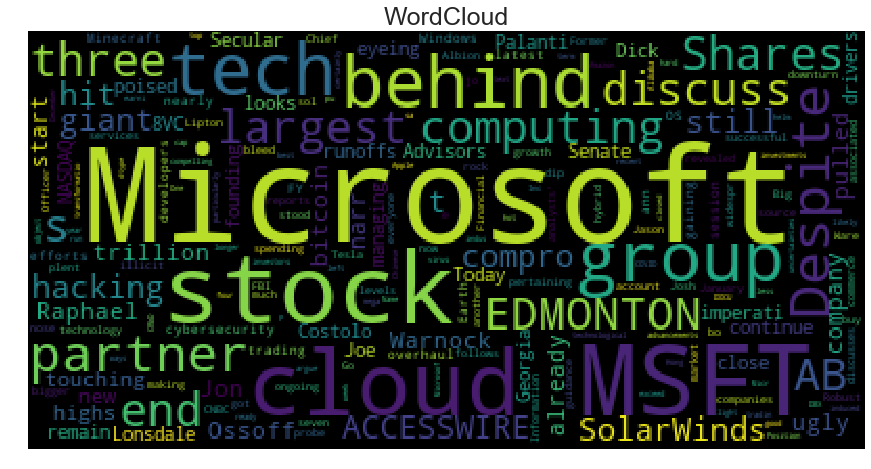

In [81]:
# Generate the word cloud
returns_big_text= ''.join (str (text_sentiment_polarity["text"]))

returns_wc= WordCloud().generate(returns_big_text)

plt.imshow(returns_wc)
plt.axis("off")
plt.title('WordCloud', fontsize= 25)
plt.show()